Project 8: Predicting the Price of Stock
Brief description:
In this project, you are going to predict the stock price of Apple. You will use Apple (ticker AAPL) stock
historical data. You can use the date, close, and volume. Additional data we suggest you consider:
1. Historic data of a company in the same sector (correlated), e.g. META.
2. Historic data of a company whose stock prices are mostly to be anti-correlated with Apple, e.g.
EBAY.
Build a model using data from January 1, 2021 to December 31, 2022. Use your model to predict Apple
prices for the first two weeks of 2023.

https://www.nasdaq.com/market-activity/stocks/aapl/historical
https://finance.yahoo.com/lookup

# Import Relevant Modules


In [ ]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose

from numpy import arange
from pandas import read_csv
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


# Load Data, Perform Exploratory Data Analysis, and Clean Data for Processing

In [ ]:
uploaded = files.upload()

Saving Apple_Data.csv to Apple_Data.csv


In [ ]:
# Read in csv data to a dataframe
df = pd.read_csv(io.BytesIO(uploaded['Apple_Data.csv']))

In [ ]:
df.head(-10)

,Date,Close/Last,Volume,Open,High,Low
0,04/04/2023,$165.63,46278300,$166.595,$166.84,$165.11
1,04/03/2023,$166.17,56976190,$164.27,$166.29,$164.22
2,03/31/2023,$164.90,68749790,$162.44,$165.00,$161.91
3,03/30/2023,$162.36,49501690,$161.53,$162.47,$161.271
4,03/29/2023,$160.77,51305690,$159.37,$161.05,$159.35
...,...,...,...,...,...,...
1244,04/25/2018,$40.9125,113326160,$40.655,$41.355,$40.6025
1245,04/24/2018,$40.735,134699840,$41.4175,$41.5825,$40.305
1246,04/23/2018,$41.31,145586360,$41.7088,$41.73,$41.0225
1247,04/20/2018,$41.43,261083800,$42.6488,$42.8046,$41.3575


In [ ]:
print("Shape:", df.shape)
#print("The data contains observations on 5 features of AAPL stock for 1259 dates.""\n""The measured features are Opening Price for that day, Highest Price on that day, Lowest Price on that day, Closing Price for that day, and Volume sold that day.""\n""The data have 6 columns, suggesting 6 features. However, the first column gives the date. We will later reindex the data to remove this column and return a date-time index instead.")

Shape: (1259, 6)


In [ ]:
# Remove $ characters and convert observations to float values
df['Close/Last'] = df['Close/Last'].str.replace("$",'', regex=True)
df['Close/Last'] = df['Close/Last'].astype(float)
df['Open'] = df['Open'].str.replace("$",'', regex=True)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].str.replace("$",'', regex=True)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].str.replace("$",'', regex=True)
df['Low'] = df['Low'].astype(float)

Check for null values to avoid outliers in training


In [ ]:
print("Null Values?:", df.isnull().values.any())
print("If there were missing values in the data, we would need to remove these observations or interpolate to find a valid estimate for them.")

Null Values?: False
If there were missing values in the data, we would need to remove these observations or interpolate to find a valid estimate for them.


Isolate observations in the timeframe 2021-2022

In [ ]:
# Define df_apple as a dataframe containing observations from 2021-20022
df_apple = df[df["Date"].str.contains("2021|2022")]
# Reindex df_apple to use a date-time index in chronological order.
df_apple = df_apple.loc[::-1].reset_index(drop=True)
df_apple = df_apple.set_index(pd.DatetimeIndex(df_apple['Date']))
df_apple['Date'] = pd.to_datetime(df_apple.Date, format="%m/%d/%Y")

In [ ]:
df_apple.head(-2)

,Date,Close/Last,Volume,Open,High,Low
Date,,,,,,
2021-01-04,2021-01-04,129.41,143301900,133.520,133.6116,126.760
2021-01-05,2021-01-05,131.01,97664900,128.890,131.7400,128.430
2021-01-06,2021-01-06,126.60,155088000,127.720,131.0499,126.382
2021-01-07,2021-01-07,130.92,109578200,128.360,131.6300,127.860
2021-01-08,2021-01-08,132.05,105158200,132.430,132.6300,130.230
...,...,...,...,...,...,...
2022-12-21,2022-12-21,135.45,85927990,132.980,136.8100,132.750
2022-12-22,2022-12-22,132.23,77852110,134.352,134.5600,130.300
2022-12-23,2022-12-23,131.86,63814890,130.920,132.4150,129.640


In [ ]:
print("There are 503 dates with observed price data during the years 2021 and 2022")
print("After reindexing, our data now contains only 5 explanatory features: Close/Last Price, Volume, Opening Price, Highest Price, and Lowest Price for a given date.""\n""The 6th feature is the given date.")

Shape: (503, 6)
There are 503 dates with observed price data during the years 2021 and 2022
After reindexing, our data now contains only 5 explanatory features: Close/Last Price, Volume, Opening Price, Highest Price, and Lowest Price for a given date.
The 6th feature is the given date.


In [ ]:
print(df_apple.describe())
print("Mean values for Close, Open, High, and Low prices show that the average value for AAPL stock fell between $147 and $149 in 2021 and 2022.""\n""Minima and maxima reveal that AAPL stock reached prices as low as $116 and as high as $182 during this timeframe.")

       Close/Last        Volume        Open        High         Low
count  503.000000  5.030000e+02  503.000000  503.000000  503.000000
mean   147.898429  8.923537e+07  147.818085  149.613199  146.069436
std     15.503697  2.658691e+07   15.449531   15.662776   15.286482
min    116.360000  3.519586e+07  119.030000  120.403100  116.210000
25%    135.380000  7.091765e+07  135.745000  137.025000  133.750000
50%    147.060000  8.450576e+07  147.030000  148.820000  145.630000
75%    159.260000  1.022806e+08  159.577500  161.970000  156.626400
max    182.010000  1.959234e+08  182.630000  182.940000  179.120000
Mean values for Close, Open, High, and Low prices show that the average value for AAPL stock fell between $147 and $149 in 2021 and 2022.
Minima and maxima reveal that AAPL stock reached prices as low as $116 and as high as $182 during this timeframe.


Plot AAPL Closing Stock Prices from 1/1/2021 through 12/30/2022




<function matplotlib.pyplot.show(close=None, block=None)>

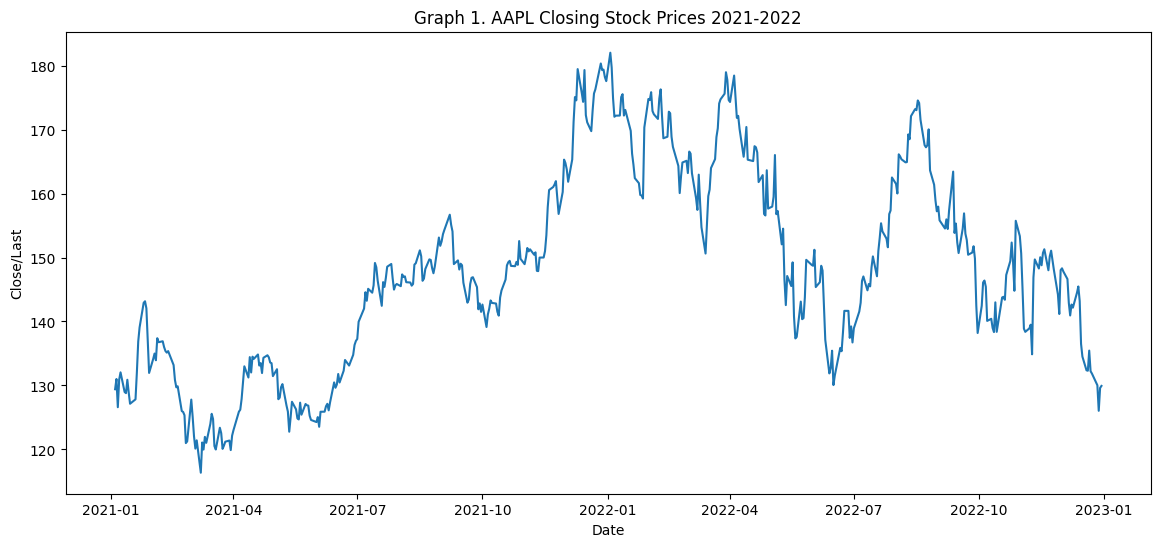

In [ ]:
plt.figure(figsize = (14,6))
sns.lineplot(data=df_apple, x="Date", y="Close/Last")
plt.title("Graph 1. AAPL Closing Stock Prices 2021-2022")
plt.show


Decompose stock prices into trends, seasonality, and residuals to explain variation shown above
* The trend graph shows the overall movement of the stock price from 2021-2022.
* The seasonal graph returns any repeating patterns that occur over regular intervals, likely resulting from seasonal factors.
* The residual graph shows the "noise" or any irregular components in stock price fluctuations after controlling for trends and seasonal effects.

Graph 2. Seasonal Decomposition of Closing Stock Prices 2021-2022


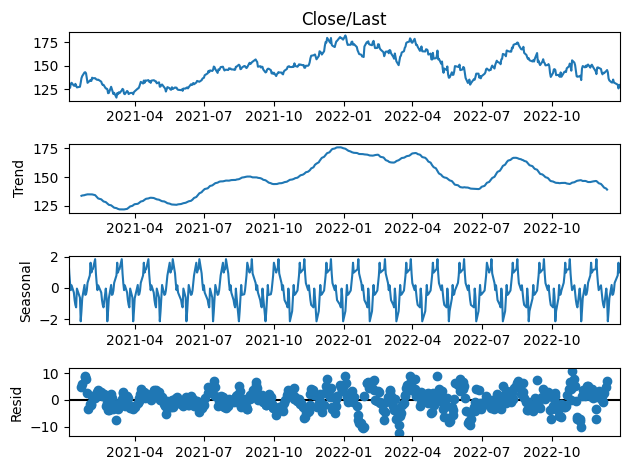

The trend portion of our decomposition shows that AAPL closing stock prices rose from a relative low in early 2021 to a relative high in early 2022, before declining again from 01/2022 to 06/2022.
Closing stock prices then rose from 07/2022 to 09/2022, before declining again, albeit not reaching lows as severe as in early 2021.
Seasonal fluctuations in stock prices can explain away some of the noise shown in the raw data given above.
The presence of residual error suggests that stock prices sometimes fluctuated due to factors other than time.
However, this observation is concordant with our knowledge of the stock market, where prices often fluctuate in response to extraneous variables.


In [ ]:
print("Graph 2. Seasonal Decomposition of Closing Stock Prices 2021-2022")
decomp = seasonal_decompose(x=df_apple['Close/Last'], period=24, model = 'additive')
decomp.plot()
plt.show()


print(
    "The trend portion of our decomposition shows that AAPL closing stock prices rose from a relative low in early 2021 to a relative high in early 2022, before declining again from 01/2022 to 06/2022."
    "\n""Closing stock prices then rose from 07/2022 to 09/2022, before declining again, albeit not reaching lows as severe as in early 2021."
    "\n""Seasonal fluctuations in stock prices can explain away some of the noise shown in the raw data given above."
    "\n""The presence of residual error suggests that stock prices sometimes fluctuated due to factors other than time."
    "\n""However, this observation is concordant with our knowledge of the stock market, where prices often fluctuate in response to extraneous variables.")

# Modeling Time Series Data

Normalize data to begin fitting a predictive model

In [ ]:
df_scaled = df_apple
for col in df_apple.columns:
    df_apple[col] = MinMaxScaler(feature_range = (0,1)).fit_transform(df_apple[col].to_numpy().reshape(-1,1))

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
df_scaled = scaler.fit_transform(df_apple)
# df_scaled gives the scaled, time indexed dataframe with observations from 2021 and 2022
df_scaled = pd.DataFrame(columns=df_apple.columns, data = df_scaled, index = df_apple.index)

In [ ]:
df_scaled

,Date,Close/Last,Volume,Open,High,Low
Date,,,,,,
2021-01-04,0.000000,0.198781,0.672604,0.227830,0.211211,0.167700
2021-01-05,0.001379,0.223153,0.388664,0.155031,0.181283,0.194246
2021-01-06,0.002759,0.155979,0.745934,0.136635,0.170248,0.161691
2021-01-07,0.004138,0.221782,0.462785,0.146698,0.179524,0.185185
2021-01-08,0.005517,0.238995,0.435285,0.210692,0.195515,0.222858
...,...,...,...,...,...,...
2022-12-23,0.990345,0.236101,0.178059,0.186950,0.192077,0.213480
2022-12-27,0.995862,0.208225,0.210368,0.194182,0.176006,0.198856
2022-12-28,0.997241,0.147449,0.312594,0.167296,0.169890,0.153553


Define target variables and features

In [ ]:
# The target variable "Close/Last" is given by target_y
target_y = df_scaled['Close/Last']
# Convert target_y to a dataframe for visualization later
target_y_df = pd.DataFrame(data = target_y)

# Define features as the additional scaled observations in our dataset and store in the dataframe features_df
features = ['Date','Open','High','Low','Volume']
#features = ['Date','Volume']
features_df = df_scaled[features]
features_df = pd.DataFrame(columns=features, data=features_df, index=df_scaled.index)

Split the dataset into training and testing samples.
* We use the method TimeSeriesSplit from scikitlearn to divide our data
* TimeSeriesSplit takes into account the temporal aspect of time series data, prohibiting our model from training based on future predictions.

In [ ]:
# Define n_splits = 3 to yield a 70-30 training/testing split
split = TimeSeriesSplit(n_splits=3)

# Loop through the data to produce four dataframes: X_train (70% of feature values), X_test (30% of feature values), y_train (70% of closing stock prices), and y_test (30% of closing stock prices)
for train_index, test_index in split.split(features_df):
        X_train, X_test = features_df[:len(train_index)], features_df[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_y_df[:len(train_index)], target_y_df[len(train_index): (len(train_index)+len(test_index))]

Plot the training/ testing split of closing AAPL stock prices during 2021 and 2022.

<function matplotlib.pyplot.show(close=None, block=None)>

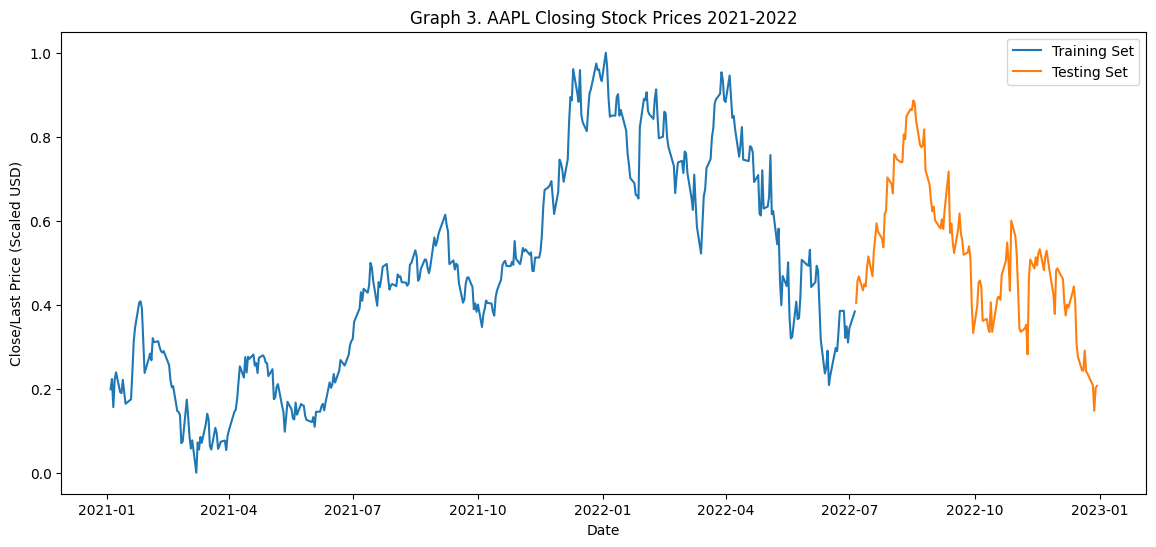

In [ ]:
plt.figure(figsize = (14,6))

plt.plot(y_train['Close/Last'])
plt.plot(y_test['Close/Last'])
plt.xlabel('Date')
plt.ylabel('Close/Last Price (Scaled USD)')
plt.legend(['Training Set', 'Testing Set'])
plt.title("Graph 3. AAPL Closing Stock Prices 2021-2022")
plt.show

Reshape the data for use in training the LSTM model.

In [ ]:
# Convert data to numpy arrays
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()
X_train1 = np.array(X_train)
X_test1 = np.array(X_test)

In [ ]:
# Reshape X_train and X_test to 3 dimensions for use in the LSTM model
X_train_array = X_train1.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_array = X_test1.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
# Verify shapes of training and testing arrays
print(X_train_array.shape)
print(X_test_array.shape)
print(y_test.shape)
print(y_train.shape)

(378, 1, 5)
(125, 1, 5)
(125,)
(378,)


Create and initialize the LSTM model

* The Long Short-Term Memory (LSTM) model is a Recurrent Neural Network (RNN). RNNs are effective in analyzing time series data, as they take the temporal aspect of the data into account, looking for sequential patterns.

* The sigmoid activation function is most commonly used in RNNs

* LSTM overcomes the vanishing gradient problem, where small inputs run through a sigmoid or tanh activation function produce exponentially small outputs, making the model difficult to train

* We define Mean Squared Error as our loss function, to be evaluated after training  

* The Early Stopping Method can help us avoid overfitting by stopping the model after 10 epochs of no significant reductions in MSE

In [ ]:
# Define a sequential model
model = Sequential()

# Define the LSTM neural net with 32 hidden states
# Define the activation and recurrent activation functions as tanh and sigmoid respectively, as suggested by the keras documentation
# Define an output layer with number of neurons = 1
model.add(LSTM(4, input_shape=(1, X_train1.shape[1]), activation='tanh', return_sequences=False))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss= 'mean_squared_error', optimizer='adam')
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)

In [ ]:
history = model.fit(X_train_array, y_train, validation_data=(X_test_array, y_test), epochs=100, batch_size=30, verbose=1, shuffle=False, callbacks=[callback])

Epoch 1/100
13/13 [==============================] - 3s 52ms/step - loss: 0.0628 - val_loss: 0.0253
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0621 - val_loss: 0.0252
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0617 - val_loss: 0.0251
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0613 - val_loss: 0.0249
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0609 - val_loss: 0.0248
Epoch 6/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0606 - val_loss: 0.0247
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0602 - val_loss: 0.0245
Epoch 8/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0598 - val_loss: 0.0244
Epoch 9/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0594 - val_loss: 0.0243
Epoch 10/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0590 - val_loss: 0.0241
Epoch 11

Evaluate the use of Mean Squared Error as a loss function for this model.


In [ ]:
train_mse = model.evaluate(X_train_array, y_train, verbose=1)
test_mse = model.evaluate(X_test_array, y_test, verbose=1)
print('Training Loss: %.3f, Testing Loss: %.3f' % (train_mse, test_mse))

4/4 [==============================] - 0s 4ms/step - loss: 0.0044
Training Loss: 0.004, Testing Loss: 0.004


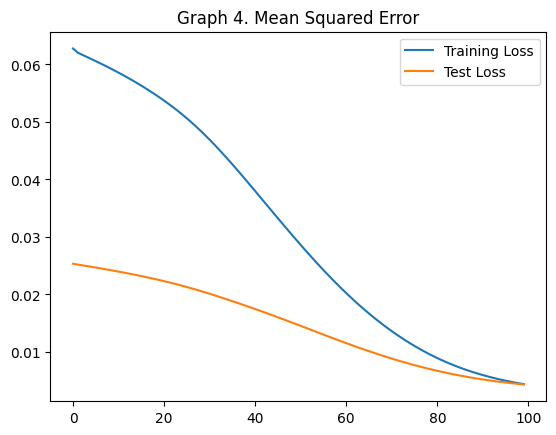

MSE for training and test data are both low and converge quickly, indicating that MSE works well as a loss function for our LSTM model.


In [ ]:
plt.title('Graph 4. Mean Squared Error')
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend()
plt.show()
print("MSE for training and test data are both low and converge quickly, indicating that MSE works well as a loss function for our LSTM model.")

In [ ]:
y_pred = model.predict(X_test_array)


4/4 [==============================] - 1s 4ms/step


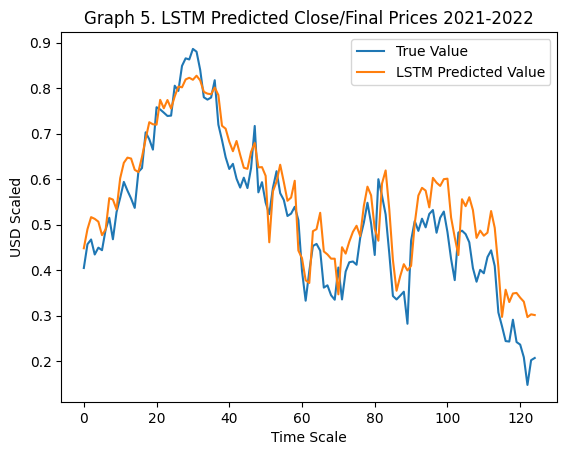

In [ ]:
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Predicted Value')
plt.title('Graph 5. LSTM Predicted Close/Final Prices 2021-2022')
plt.xlabel('Time Scale')
plt.ylabel('USD Scaled')
plt.legend()
plt.show()

# Apply LSTM model to predict stock prices in 2023

Apply LSTM model to predict stock prices for 2023

In [ ]:
df_2023 = df[df["Date"].str.contains("2023")]

In [ ]:
df_2023 = df_2023.loc[::-1].reset_index(drop=True)
df_2023 = df_2023.set_index(pd.DatetimeIndex(df_2023['Date']))
df_2023['Date'] = pd.to_datetime(df_2023.Date, format="%m/%d/%Y")
df_2023 = df_2023.iloc[:14]

In [ ]:
df_2023

,Date,Close/Last,Volume,Open,High,Low
Date,,,,,,
2023-01-03,2023-01-03,125.07,112117500,130.280,130.9000,124.17
2023-01-04,2023-01-04,126.36,89113630,126.890,128.6557,125.08
2023-01-05,2023-01-05,125.02,80962710,127.130,127.7700,124.76
2023-01-06,2023-01-06,129.62,87754720,126.010,130.2900,124.89
2023-01-09,2023-01-09,130.15,70790810,130.465,133.4100,129.89
2023-01-10,2023-01-10,130.73,63896160,130.260,131.2636,128.12
2023-01-11,2023-01-11,133.49,69458950,131.250,133.5100,130.46
2023-01-12,2023-01-12,133.41,71379650,133.880,134.2600,131.44
2023-01-13,2023-01-13,134.76,57809720,132.030,134.9200,131.66


<function matplotlib.pyplot.show(close=None, block=None)>

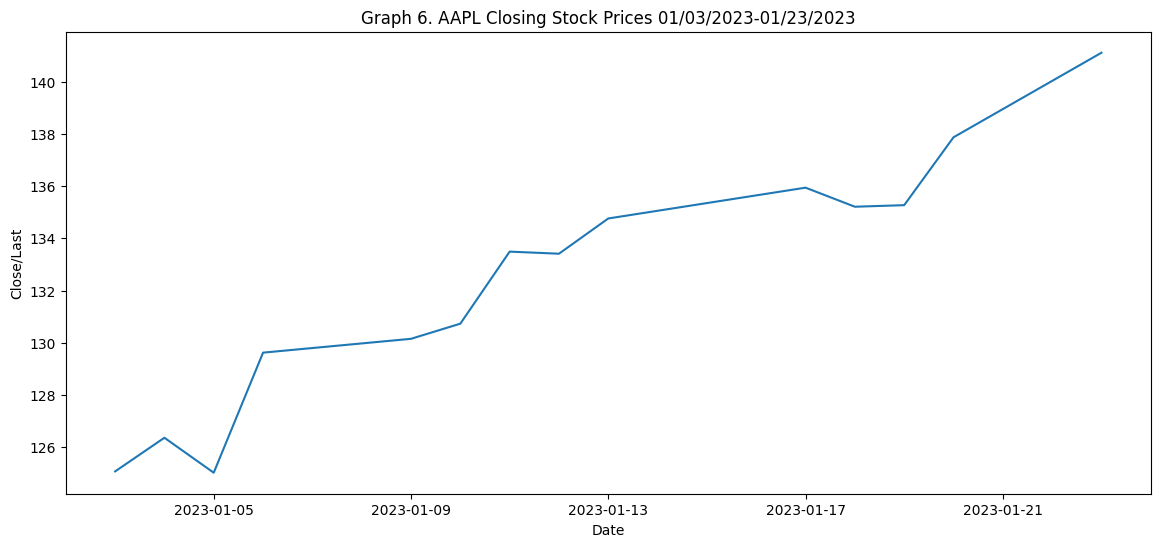

In [ ]:
plt.figure(figsize = (14,6))
sns.lineplot(data=df_2023, x="Date", y="Close/Last")
plt.title("Graph 6. AAPL Closing Stock Prices 01/03/2023-01/23/2023")
plt.show

In [ ]:
df_2023_scaled = df_2023
for col in df_2023.columns:
    df_2023[col] = MinMaxScaler(feature_range = (0,1)).fit_transform(df_2023[col].to_numpy().reshape(-1,1))

In [ ]:
features_2023 = df_2023_scaled[features]
features_2023 = pd.DataFrame(columns=features, data=features_2023, index=df_2023_scaled.index)

In [ ]:
X_test2 = np.array(features_2023)
X_test_2023 = X_test2.reshape(X_test2.shape[0], 1, X_test2.shape[1])

In [ ]:
y_test_2023 = np.array(df_2023_scaled['Close/Last'])

In [ ]:
y_pred_2023 = model.predict(X_test_2023)

1/1 [==============================] - 0s 23ms/step


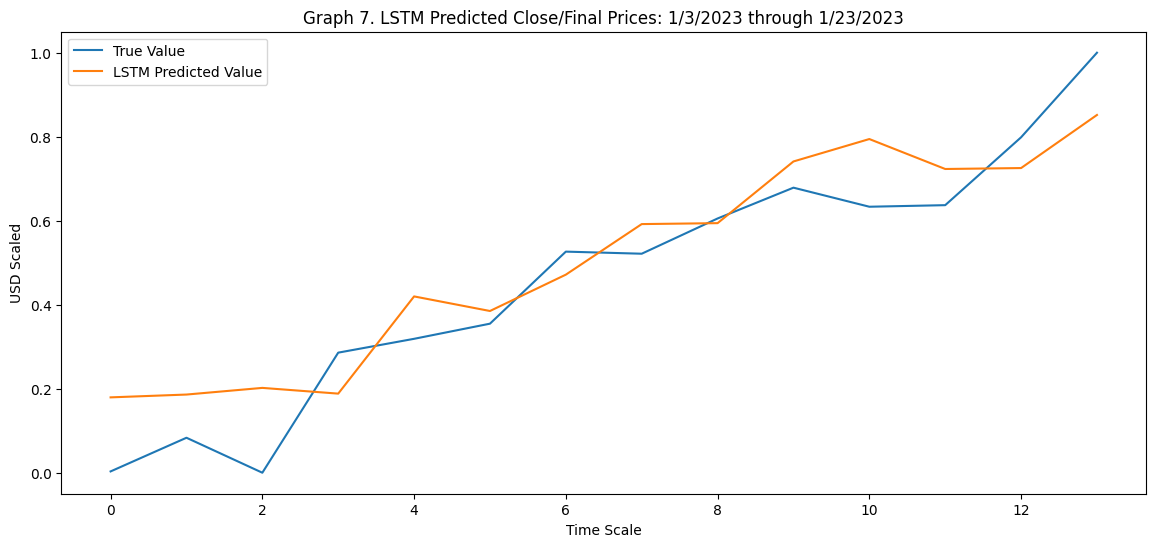

In [ ]:
plt.figure(figsize = (14,6))
plt.plot(y_test_2023, label='True Value')
plt.plot(y_pred_2023, label='LSTM Predicted Value')
plt.title('Graph 7. LSTM Predicted Close/Final Prices: 1/3/2023 through 1/23/2023')
plt.xlabel('Time Scale')
plt.ylabel('USD Scaled')
plt.legend()
plt.show()

# Random Forest

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from numpy import arange
from pandas import read_csv
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
# removes the $ and changes values into floats
df = pd.read_csv("./Apple_Data.csv")
df_apple = df
df_apple = df_apple[df_apple["Date"].str.contains("2021|2022")]
df_apple['Close/Last'] = df_apple["Close/Last"].str.replace('$', '')
df_apple['Close/Last'] = df_apple['Close/Last'].astype(float)

df_apple["Open"] = df_apple["Open"].str.replace('$', '')
df_apple['Open'] = df_apple['Open'].astype(float)

df_apple['High'] = df_apple["High"].str.replace('$', '')
df_apple['High'] = df_apple['High'].astype(float)

df_apple['Low'] = df_apple["Low"].str.replace('$', '')
df_apple['Low'] = df_apple['Low'].astype(float)

<ipython-input-41-48adf11f3eea>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_apple['Close/Last'] = df_apple["Close/Last"].str.replace('$', '')
<ipython-input-41-48adf11f3eea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple['Close/Last'] = df_apple["Close/Last"].str.replace('$', '')
<ipython-input-41-48adf11f3eea>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [ ]:
# Remove $ characters and convert observations to float values
df['Close/Last'] = df['Close/Last'].str.replace("$",'', regex=True)
df['Close/Last'] = df['Close/Last'].astype(float)
df['Open'] = df['Open'].str.replace("$",'', regex=True)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].str.replace("$",'', regex=True)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].str.replace("$",'', regex=True)
df['Low'] = df['Low'].astype(float)


In [ ]:
# Define df_apple as a dataframe containing observations from 2021-20022
df_apple = df[df["Date"].str.contains("2021|2022")]
# Reindex df_apple to use a date-time index in chronological order.
df_apple = df_apple.loc[::-1].reset_index(drop=True)
df_apple = df_apple.set_index(pd.DatetimeIndex(df_apple['Date']))
df_apple['Date'] = pd.to_datetime(df_apple.Date, format="%m/%d/%Y")


In [ ]:
df_scaled = df_apple
for col in df_apple.columns:
    df_apple[col] = MinMaxScaler(feature_range = (0,1)).fit_transform(df_apple[col].to_numpy().reshape(-1,1))

scaler = MinMaxScaler(feature_range = (0,1))
df_scaled = scaler.fit_transform(df_apple)
# df_scaled gives the scaled, time indexed dataframe with observations from 2021 and 2022
df_scaled = pd.DataFrame(columns=df_apple.columns, data = df_scaled, index = df_apple.index)

In [ ]:
# The target variable "Close/Last" is given by target_y
target_y = df_scaled['Close/Last']
# Convert target_y to a dataframe for visualization later
target_y_df = pd.DataFrame(data = target_y)

# Define features as the additional scaled observations in our dataset and store in the dataframe features_df
features = ['Date','Open','High','Low','Volume']
#features = ['Date','Volume']
features_df = df_scaled[features]
features_df = pd.DataFrame(columns=features, data=features_df, index=df_scaled.index)


In [ ]:
# Define n_splits = 3 to yield a 70-30 training/testing split
split = TimeSeriesSplit(n_splits=3)

# Loop through the data to produce four dataframes: X_train (70% of feature values), X_test (30% of feature values), y_train (70% of closing stock prices), and y_test (30% of closing stock prices)
for train_index, test_index in split.split(features_df):
        X_train, X_test = features_df[:len(train_index)], features_df[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_y_df[:len(train_index)], target_y_df[len(train_index): (len(train_index)+len(test_index))]


In [ ]:
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()
X_train1 = np.array(X_train)
X_test1 = np.array(X_test)

# Reshape X_train and X_test to 2 dimensions for use in the KNN model
X_train_array = X_train1.reshape(X_train.shape[0], X_train.shape[1])
X_test_array = X_test1.reshape(X_test.shape[0], X_test.shape[1])


In [ ]:
model = RandomForestRegressor(n_estimators=50, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
model.fit(X_train_array, y_train)

# make predictions on the test data
y_pred = model.predict(X_test_array)

y_test_df = pd.DataFrame(y_test)
y_test_14 = y_test_df.iloc[:14]
y_pred_df = pd.DataFrame(y_pred)
y_pred_14 = y_pred_df.iloc[:14]

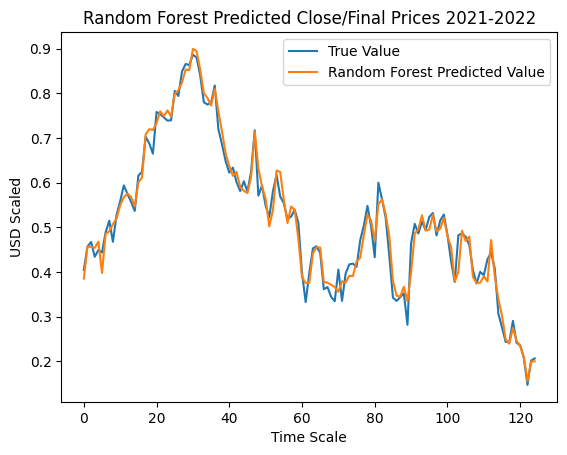

In [ ]:
# plot the data
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='Random Forest Predicted Value')
plt.title('Random Forest Predicted Close/Final Prices 2021-2022')
plt.xlabel('Time Scale')
plt.ylabel('USD Scaled')
plt.legend()
plt.show()


In [ ]:
# get the actual data from the first 14 data points from 2023
df_2023 = df[df["Date"].str.contains("2023")]

df_2023 = df_2023.loc[::-1].reset_index(drop=True)
df_2023 = df_2023.set_index(pd.DatetimeIndex(df_2023['Date']))
df_2023['Date'] = pd.to_datetime(df_2023.Date, format="%m/%d/%Y")
df_2023 = df_2023.iloc[:14]


In [ ]:
# predicts the first 14 data points of 2023
df_2023_scaled = df_2023
for col in df_2023.columns:
    df_2023[col] = MinMaxScaler(feature_range = (0,1)).fit_transform(df_2023[col].to_numpy().reshape(-1,1))

features_2023 = df_2023_scaled[features]
features_2023 = pd.DataFrame(columns=features, data=features_2023, index=df_2023_scaled.index)

X_test_2023 = np.array(features_2023)
X_test_2023 = X_test_2023.reshape(X_test_2023.shape[0], X_test_2023.shape[1])

scaler = MinMaxScaler(feature_range=(0, 1))
X_test_2023 = scaler.fit_transform(X_test_2023)

y_test_2023 = np.array(df_2023_scaled['Close/Last'])
y_pred_2023 = model.predict(X_test_2023)

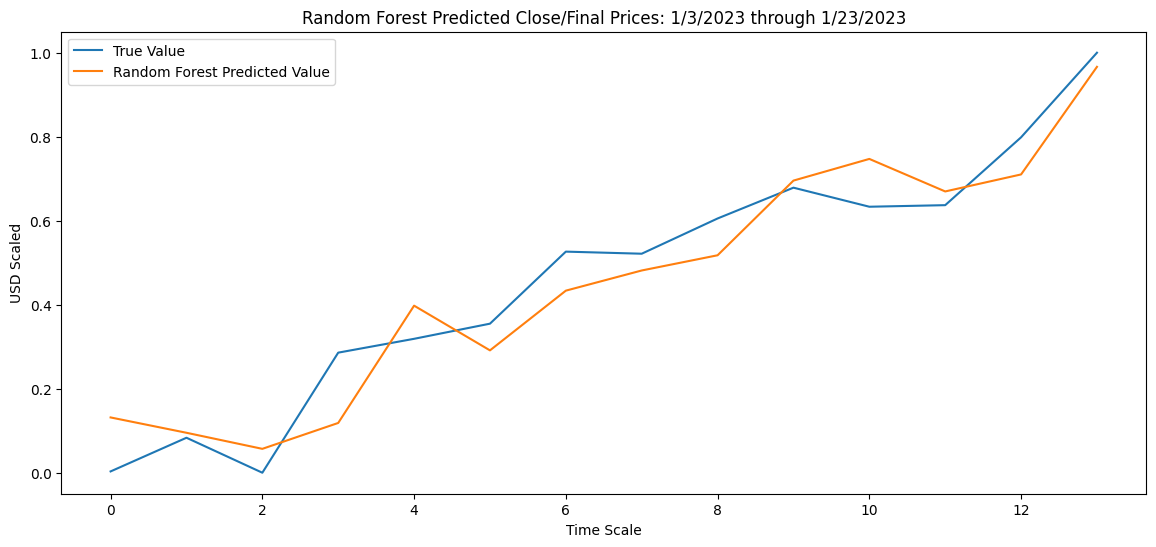

In [ ]:
plt.figure(figsize = (14,6))
plt.plot(y_test_2023, label='True Value')
plt.plot(y_pred_2023, label='Random Forest Predicted Value')
plt.title('Random Forest Predicted Close/Final Prices: 1/3/2023 through 1/23/2023')
plt.xlabel('Time Scale')
plt.ylabel('USD Scaled')
plt.legend()
plt.show()

In [ ]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, y_pred), 14))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, y_pred), 14))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 14))
print("(R^2) Score:", round(metrics.r2_score(y_test, y_pred), 14))
errors = abs(y_pred - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Mean Absolute Percentage Error:', 100 - round(accuracy, 2), '%.')

Mean Absolute Error: 0.0187538539926
Mean Squared Error: 0.00059986061311
Root Mean Squared Error: 0.02449205203951
(R^2) Score: 0.97733516640039
Mean Absolute Percentage Error: 4.019999999999996 %.


# KNN

In [ ]:
# Creates the knn model since all the preprocessing has been completed above
k = 100 # number of neighbors
model2 = KNeighborsRegressor(n_neighbors=k, weights='uniform')
model2.fit(X_train_array, y_train)


KNeighborsRegressor(n_neighbors=100)

In [ ]:
# use the knn model in order to make predictions
y_pred = model2.predict(X_test_array)

y_test_df = pd.DataFrame(y_test)
y_test_14 = y_test_df.iloc[:14]
y_pred_df = pd.DataFrame(y_pred)
y_pred_14 = y_pred_df.iloc[:14]

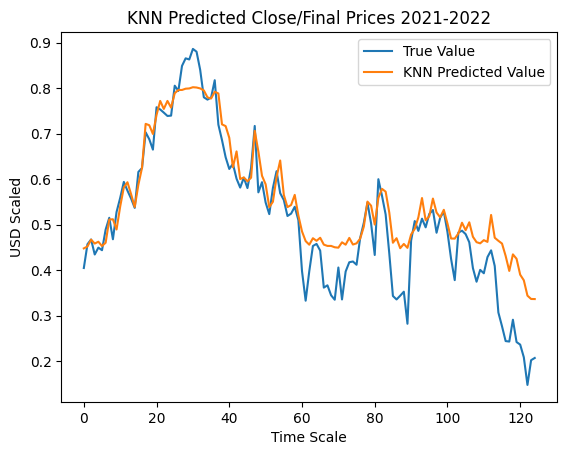

In [ ]:
# plot the data
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='KNN Predicted Value')
plt.title('KNN Predicted Close/Final Prices 2021-2022')
plt.xlabel('Time Scale')
plt.ylabel('USD Scaled')
plt.legend()
plt.show()


In [ ]:
# predicts the data of the first 14 points of 2023
y_test_2023 = np.array(df_2023_scaled['Close/Last'])
y_pred_2023 = model.predict(X_test_2023)


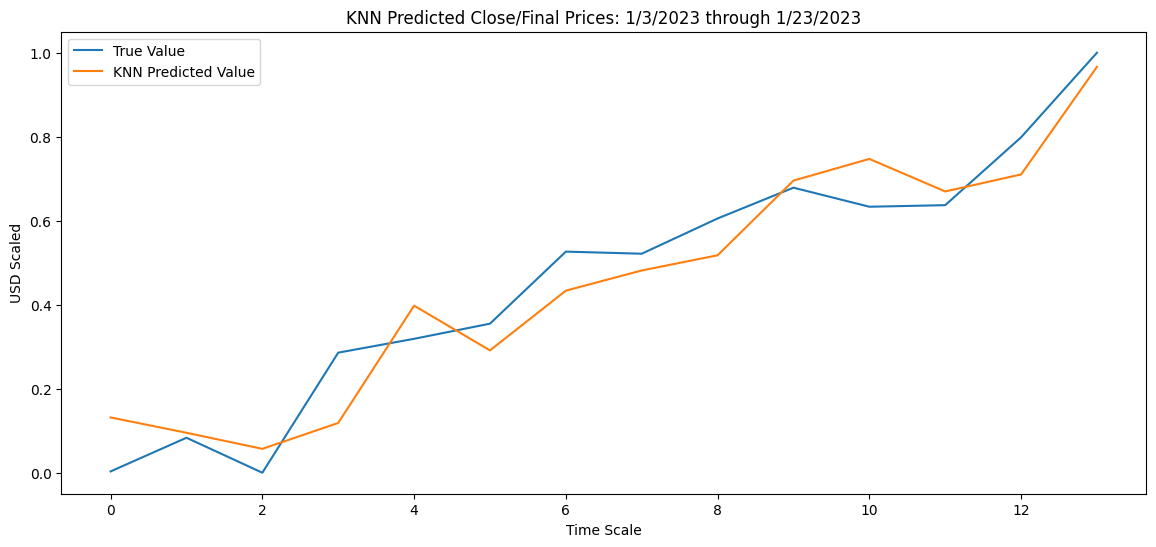

In [ ]:
# plot the predictions
plt.figure(figsize = (14,6))
plt.plot(y_test_2023, label='True Value')
plt.plot(y_pred_2023, label='KNN Predicted Value')
plt.title('KNN Predicted Close/Final Prices: 1/3/2023 through 1/23/2023')
plt.xlabel('Time Scale')
plt.ylabel('USD Scaled')
plt.legend()
plt.show()

In [ ]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, y_pred), 14))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, y_pred), 14))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 14))
print("(R^2) Score:", round(metrics.r2_score(y_test, y_pred), 14))
errors = abs(y_pred - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Mean Absolute Percentage Error:', 100 - round(accuracy, 2), '%.')

Mean Absolute Error: 0.05112378979436
Mean Squared Error: 0.00500912577367
Root Mean Squared Error: 0.07077517766613
(R^2) Score: 0.81073769529233
Mean Absolute Percentage Error: 14.569999999999993 %.


# Comparing Different Companies

In [ ]:
uploaded = files.upload()
df_meta = pd.read_csv(io.BytesIO(uploaded['Meta_Data.csv']))

In [ ]:
df_meta = df_meta[["Date","Close/Last","Volume"]]
df_meta = df_meta[df_meta["Date"].str.contains("2021|2022")]
df_meta['Close/Last'] = df_meta["Close/Last"].str.replace('$', '')
df_meta['Close/Last'] = df_meta['Close/Last'].astype(float)
df_meta = df_meta.loc[::-1].reset_index(drop=True)
df_meta = df_meta.set_index(pd.DatetimeIndex(df_meta['Date']))
df_meta = df_meta.drop(['Date'], axis=1)

# normalize
df_meta_scaled = df_meta
for col in df_meta.columns:
    df_meta[col] = MinMaxScaler(feature_range = (0,1)).fit_transform(df_meta[col].to_numpy().reshape(-1,1))
scaler = MinMaxScaler(feature_range = (0,1))
df_meta_scaled = scaler.fit_transform(df_meta)
df_meta_scaled = pd.DataFrame(columns=df_meta.columns, data = df_meta_scaled, index = df_meta.index)

<ipython-input-55-54275e2648ff>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_meta['Close/Last'] = df_meta["Close/Last"].str.replace('$', '')


In [ ]:
uploaded = files.upload()
df_ebay = pd.read_csv(io.BytesIO(uploaded['Ebay_Data.csv']))

Saving Ebay_Data.csv to Ebay_Data.csv


In [ ]:
df_ebay = df_ebay[["Date","Close/Last","Volume"]]
df_ebay = df_ebay[df_ebay["Date"].str.contains("2021|2022")]
df_ebay['Close/Last'] = df_ebay["Close/Last"].str.replace('$', '')
df_ebay['Close/Last'] = df_ebay['Close/Last'].astype(float)
df_ebay = df_ebay.loc[::-1].reset_index(drop=True)
df_ebay = df_ebay.set_index(pd.DatetimeIndex(df_ebay['Date']))
df_ebay = df_ebay.drop(['Date'], axis=1)

# normalize
df_ebay_scaled = df_ebay
for col in df_meta.columns:
    df_ebay[col] = MinMaxScaler(feature_range = (0,1)).fit_transform(df_ebay[col].to_numpy().reshape(-1,1))
scaler = MinMaxScaler(feature_range = (0,1))
df_ebay_scaled = scaler.fit_transform(df_ebay)
# df_scaled gives the scaled, time indexed dataframe with observations from 2021 and 2022
df_ebay_scaled = pd.DataFrame(columns=df_ebay.columns, data = df_ebay_scaled, index = df_ebay.index)

<ipython-input-57-77788dc663a3>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_ebay['Close/Last'] = df_ebay["Close/Last"].str.replace('$', '')


Measure Correlation Between Stocks

In [ ]:
df_apple_scaled = df_scaled
df_closing = df_apple_scaled[['Close/Last']].copy()
df_closing = df_closing.rename(columns={'Close/Last':'Apple'})
df_closing['Meta'] = df_meta_scaled['Close/Last']
df_closing['Ebay'] = df_ebay_scaled['Close/Last']
df_closing

,Apple,Meta,Ebay
Date,,,
2021-01-04,0.198781,0.613871,0.335541
2021-01-05,0.223153,0.620793,0.347647
2021-01-06,0.155979,0.594674,0.374829
2021-01-07,0.221782,0.613189,0.371174
2021-01-08,0.238995,0.609200,0.403609
...,...,...,...
2022-12-23,0.236101,0.099328,0.076747
2022-12-27,0.208225,0.095373,0.074692
2022-12-28,0.147449,0.091076,0.071037


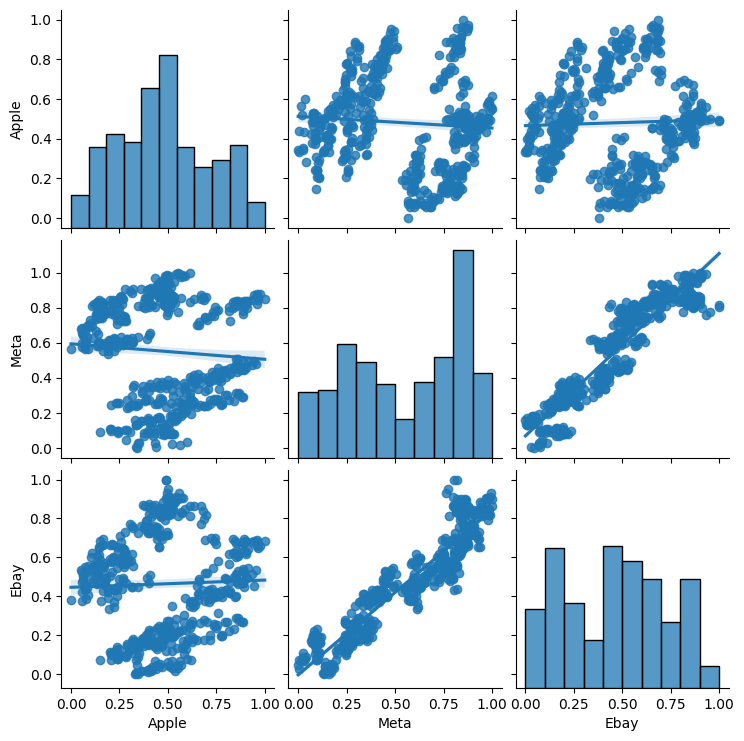

In [ ]:
sns.pairplot(df_closing, kind='reg')

Text(0.5, 1.0, 'Correlation of stock closing price')

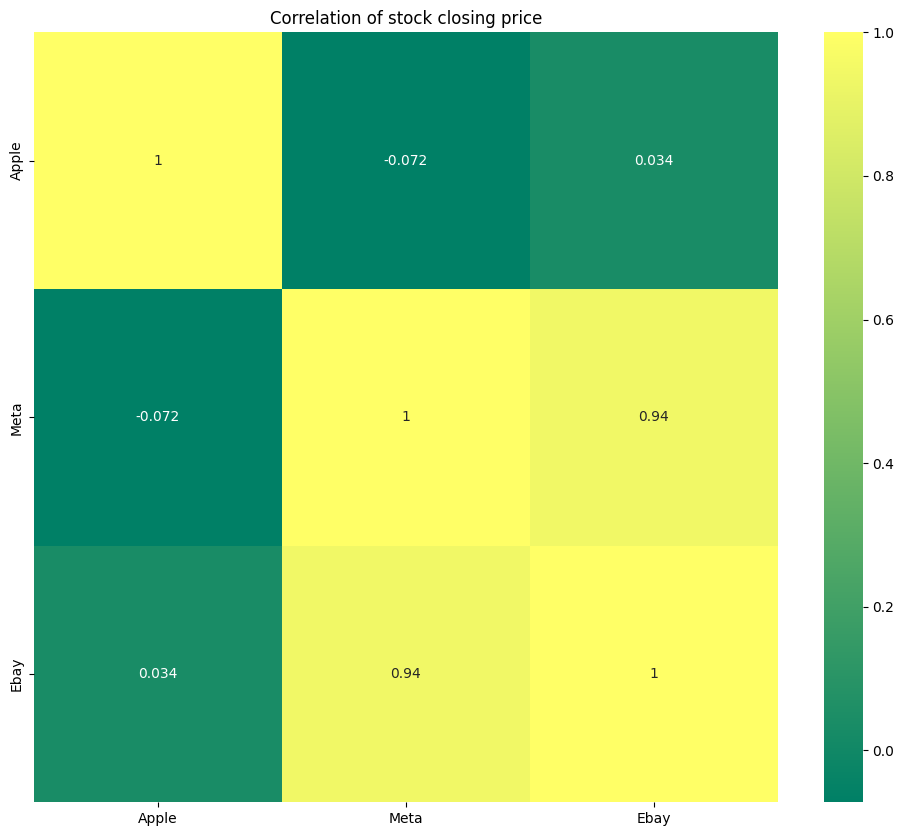

In [ ]:
plt.figure(figsize=(12, 10))

sns.heatmap(df_closing.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')